In [ ]:
# Cell 1
# Mount Google Drive to save downloaded data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2
# Install required libraries (mne handles EDF files directly)
!pip install -q mne scipy matplotlib seaborn scikit-learn
print("Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 78.5 MB/s eta 0:00:00
Installation complete!


In [ ]:
# Cell 3
# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import mne
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cell 4
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Cell 5
# Define dataset paths and create directories in Google Drive
BASE_PATH = '/content/drive/MyDrive/sleep_edf_data'
PSG_PATH = os.path.join(BASE_PATH, 'psg_files')
HYPNO_PATH = os.path.join(BASE_PATH, 'hypnogram_files')
PROCESSED_PATH = os.path.join(BASE_PATH, 'processed_data')

os.makedirs(PSG_PATH, exist_ok=True)
os.makedirs(HYPNO_PATH, exist_ok=True)
os.makedirs(PROCESSED_PATH, exist_ok=True)

In [ ]:
# Cell 6
# Define function to download files from PhysioNet with progress bar
def download_file(url, save_path):
    """Download file if it doesn't exist"""
    if os.path.exists(save_path):
        return (True, f"Already exists: {os.path.basename(save_path)}")

    try:
        response = requests.get(url, stream=True, timeout=30)
        response.raise_for_status()

        total_size = int(response.headers.get('content-length', 0))

        with open(save_path, 'wb') as file:
            if total_size == 0:
                file.write(response.content)
            else:
                downloaded = 0
                for data in response.iter_content(chunk_size=8192):
                    downloaded += len(data)
                    file.write(data)

        return (True, f"Downloaded: {os.path.basename(save_path)}")
    except Exception as e:
        return (False, f"Error downloading {os.path.basename(save_path)}: {str(e)}")

def download_file_pair(psg_file, hypno_file, base_url, psg_path, hypno_path):
    """Download a PSG and Hypnogram file pair"""
    results = []

    # Download PSG file
    psg_url = base_url + psg_file
    psg_save = os.path.join(psg_path, psg_file)
    results.append(download_file(psg_url, psg_save))

    # Download Hypnogram file
    hypno_url = base_url + hypno_file
    hypno_save = os.path.join(hypno_path, hypno_file)
    results.append(download_file(hypno_url, hypno_save))

    return results

In [ ]:
# Cell 7
# Define URLs for subset of data (using 3 subjects from sleep-cassette)
BASE_URL = "https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/"

# Subject files to download (3 subjects, 2 nights each)
FILES_TO_DOWNLOAD = [
    ("SC4001E0-PSG.edf", "SC4001EC-Hypnogram.edf"),
    ("SC4002E0-PSG.edf", "SC4002EC-Hypnogram.edf"),
    ("SC4011E0-PSG.edf", "SC4011EH-Hypnogram.edf"),
    ("SC4012E0-PSG.edf", "SC4012EC-Hypnogram.edf"),
    ("SC4021E0-PSG.edf", "SC4021EH-Hypnogram.edf"),
    ("SC4022E0-PSG.edf", "SC4022EJ-Hypnogram.edf"),
]

In [ ]:
# Cell 8
# Download PSG and Hypnogram files using parallel threading
print("Downloading PSG and Hypnogram files in parallel...")
print(f"Total file pairs to download: {len(FILES_TO_DOWNLOAD)}")
print("-" * 60)

# Use ThreadPoolExecutor for parallel downloads (10 concurrent downloads)
with ThreadPoolExecutor(max_workers=10) as executor:
    # Submit all download tasks
    future_to_files = {
        executor.submit(download_file_pair, psg, hypno, BASE_URL, PSG_PATH, HYPNO_PATH): (psg, hypno)
        for psg, hypno in FILES_TO_DOWNLOAD
    }

    # Process completed downloads with progress bar
    completed = 0
    total = len(FILES_TO_DOWNLOAD)

    for future in as_completed(future_to_files):
        psg_file, hypno_file = future_to_files[future]
        try:
            results = future.result()
            for success, message in results:
                print(message)
            completed += 1
            print(f"Progress: {completed}/{total} file pairs completed")
            print("-" * 60)
        except Exception as e:
            print(f"Error processing {psg_file}: {e}")
            print("-" * 60)

print("\n✓ All downloads complete!")
print(f"Files saved to: {PSG_PATH} and {HYPNO_PATH}")

Total file pairs to download: 6
------------------------------------------------------------
Downloaded: SC4001E0-PSG.edf
Downloaded: SC4001EC-Hypnogram.edf
Progress: 1/6 file pairs completed
------------------------------------------------------------
Downloaded: SC4022E0-PSG.edf
Downloaded: SC4022EJ-Hypnogram.edf
Progress: 2/6 file pairs completed
------------------------------------------------------------
Downloaded: SC4021E0-PSG.edf
Downloaded: SC4021EH-Hypnogram.edf
Progress: 3/6 file pairs completed
------------------------------------------------------------
Downloaded: SC4012E0-PSG.edf
Downloaded: SC4012EC-Hypnogram.edf
Progress: 4/6 file pairs completed
------------------------------------------------------------
Downloaded: SC4011E0-PSG.edf
Downloaded: SC4011EH-Hypnogram.edf
Progress: 5/6 file pairs completed
------------------------------------------------------------
Downloaded: SC4002E0-PSG.edf
Downloaded: SC4002EC-Hypnogram.edf
Progress: 6/6 file pairs completed
--------

In [ ]:
# Cell 9
# Define sleep stage mapping
STAGE_MAPPING = {
    'Sleep stage W': 0,    # Wake
    'Sleep stage 1': 1,    # N1
    'Sleep stage 2': 2,    # N2
    'Sleep stage 3': 3,    # N3
    'Sleep stage 4': 3,    # N3 (combine stage 3 and 4)
    'Sleep stage R': 4,    # REM
    'Sleep stage ?': -1,   # Unknown (will be removed)
    'Movement time': -1    # Movement (will be removed)
}

STAGE_NAMES = ['Wake', 'N1', 'N2', 'N3', 'REM']

In [ ]:
# Cell 10
# Function to load and extract EEG data from PSG file
def load_eeg_data(psg_file, channel='EEG Fpz-Cz'):
    """Load EEG data from PSG file using MNE"""
    try:
        raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)

        # Get sampling frequency
        sfreq = raw.info['sfreq']

        # Select the desired EEG channel
        if channel in raw.ch_names:
            raw.pick_channels([channel])
        else:
            # Try alternative channel name
            channel = 'EEG Pz-Oz'
            if channel in raw.ch_names:
                raw.pick_channels([channel])
            else:
                print(f"Channel not found in {psg_file}")
                return None, None

        # Get data
        data = raw.get_data()[0]  # Get first (and only) channel

        return data, sfreq
    except Exception as e:
        print(f"Error loading {psg_file}: {e}")
        return None, None

In [ ]:
# Cell 11
# Function to load annotations from hypnogram file
def load_annotations(hypno_file):
    """Load sleep stage annotations from hypnogram file"""
    try:
        annotations = mne.read_annotations(hypno_file)
        return annotations
    except Exception as e:
        print(f"Error loading {hypno_file}: {e}")
        return None

In [ ]:
# Cell 12
# Function to segment EEG data into 30-second epochs
def segment_data(eeg_data, annotations, sfreq, epoch_duration=30):
    """Segment EEG data into epochs and assign labels"""
    epoch_length = int(epoch_duration * sfreq)

    epochs = []
    labels = []

    for idx, (onset, duration, description) in enumerate(zip(
        annotations.onset, annotations.duration, annotations.description)):

        # Map stage to numeric label
        if description not in STAGE_MAPPING:
            continue

        label = STAGE_MAPPING[description]

        # Skip unknown or movement stages
        if label == -1:
            continue

        # Calculate start and end samples
        start_sample = int(onset * sfreq)
        end_sample = start_sample + epoch_length

        # Check if we have enough data
        if end_sample > len(eeg_data):
            break

        # Extract epoch
        epoch = eeg_data[start_sample:end_sample]

        # Ensure epoch has correct length
        if len(epoch) == epoch_length:
            epochs.append(epoch)
            labels.append(label)

    return np.array(epochs), np.array(labels)

In [ ]:
# Cell 13
# Process all subjects and create dataset
print("Processing EEG data and creating epochs...")

all_epochs = []
all_labels = []

for psg_file, hypno_file in FILES_TO_DOWNLOAD:
    psg_path = os.path.join(PSG_PATH, psg_file)
    hypno_path = os.path.join(HYPNO_PATH, hypno_file)

    # Check if files exist
    if not os.path.exists(psg_path) or not os.path.exists(hypno_path):
        print(f"Skipping {psg_file} - files not found")
        continue

    print(f"\nProcessing: {psg_file}")

    # Load EEG data
    eeg_data, sfreq = load_eeg_data(psg_path)
    if eeg_data is None:
        continue

    # Load annotations
    annotations = load_annotations(hypno_path)
    if annotations is None:
        continue

    # Segment data
    epochs, labels = segment_data(eeg_data, annotations, sfreq)

    print(f"  Extracted {len(epochs)} epochs")
    print(f"  Label distribution: {np.bincount(labels)}")

    all_epochs.append(epochs)
    all_labels.append(labels)

# Combine all data
X = np.vstack(all_epochs)
y = np.concatenate(all_labels)

print(f"\nTotal epochs: {len(X)}")
print(f"Epoch shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

Processing EEG data and creating epochs...

Processing: SC4001E0-PSG.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  Extracted 153 epochs
  Label distribution: [12 24 40 71  6]

Processing: SC4002E0-PSG.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  Extracted 150 epochs
  Label distribution: [23 32 37 46 12]

Processing: SC4011E0-PSG.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  Extracted 125 epochs
  Label distribution: [15 33 40 29  8]

Processing: SC4012E0-PSG.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  Extracted 170 epochs
  Label distribution: [17 42 55 38 18]

Processing: SC4021E0-PSG.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  Extracted 160 epochs
  Label distribution: [ 9 22 56 58 15]

Processing: SC4022E0-PSG.edf
NOTE: pick_channels() is a legacy function. New code should use ins

In [ ]:
# Cell 14
# Save processed data to Google Drive
processed_data_file = os.path.join(PROCESSED_PATH, 'processed_epochs.npz')
np.savez(processed_data_file, X=X, y=y)
print(f"Processed data saved to: {processed_data_file}")

Processed data saved to: /content/drive/MyDrive/sleep_edf_data/processed_data/processed_epochs.npz


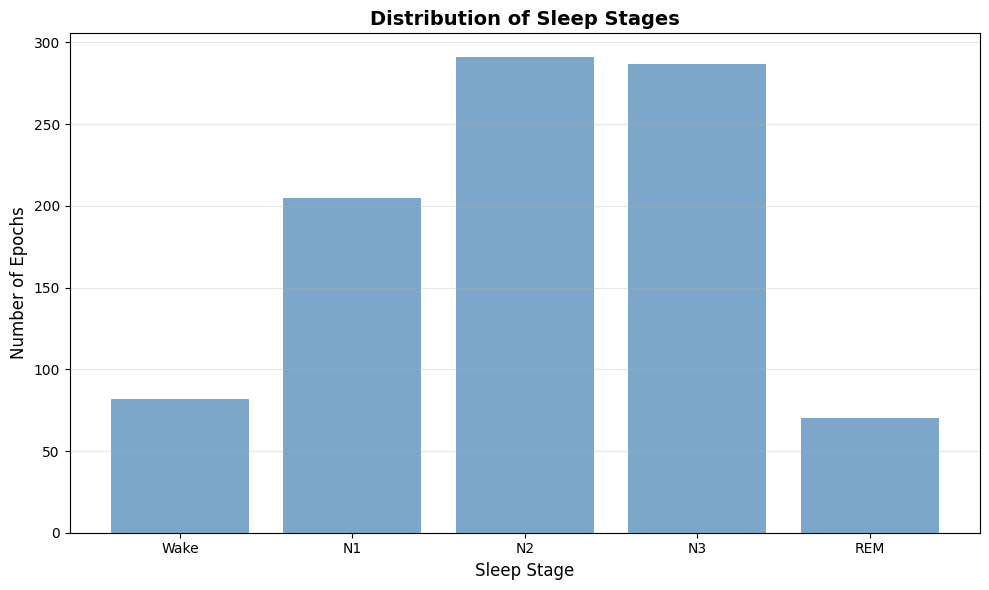

In [ ]:
# Cell 15
# Visualize class distribution
plt.figure(figsize=(10, 6))
unique, counts = np.unique(y, return_counts=True)
plt.bar([STAGE_NAMES[i] for i in unique], counts, color='steelblue', alpha=0.7)
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('Number of Epochs', fontsize=12)
plt.title('Distribution of Sleep Stages', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

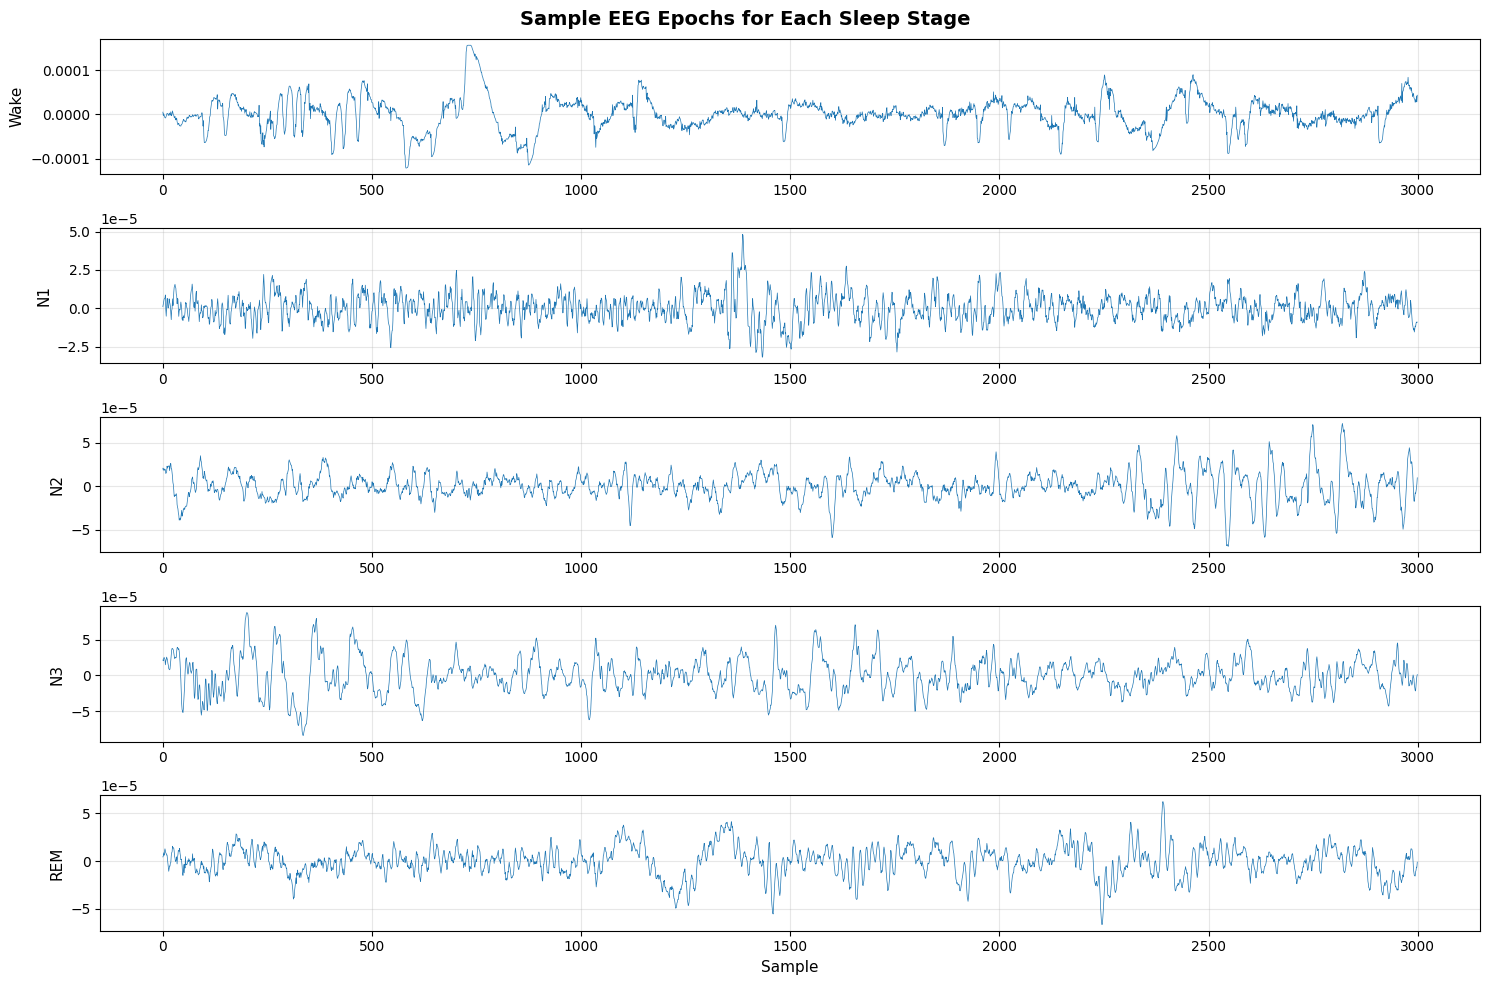

In [ ]:
# Cell 16
# Visualize sample epochs from each sleep stage
fig, axes = plt.subplots(5, 1, figsize=(15, 10))
fig.suptitle('Sample EEG Epochs for Each Sleep Stage', fontsize=14, fontweight='bold')

for stage_idx, stage_name in enumerate(STAGE_NAMES):
    # Find first epoch of this stage
    stage_epochs = X[y == stage_idx]
    if len(stage_epochs) > 0:
        sample_epoch = stage_epochs[0]
        axes[stage_idx].plot(sample_epoch, linewidth=0.5)
        axes[stage_idx].set_ylabel(stage_name, fontsize=11)
        axes[stage_idx].grid(alpha=0.3)

        if stage_idx == 4:
            axes[stage_idx].set_xlabel('Sample', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 17
# Normalize the data using StandardScaler
scaler = StandardScaler()
X_normalized = np.array([scaler.fit_transform(epoch.reshape(-1, 1)).flatten() for epoch in X])

print(f"Original data range: [{X.min():.2f}, {X.max():.2f}]")
print(f"Normalized data range: [{X_normalized.min():.2f}, {X_normalized.max():.2f}]")

Original data range: [-0.00, 0.00]
Normalized data range: [-8.06, 8.99]


In [ ]:
# Cell 18
# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_normalized, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (654, 3000), (654,)
Validation set: (140, 3000), (140,)
Test set: (141, 3000), (141,)


In [ ]:
# Cell 19
# Reshape data for TCN (add channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Reshaped training data: {X_train.shape}")
print(f"Reshaped validation data: {X_val.shape}")
print(f"Reshaped test data: {X_test.shape}")

Reshaped training data: (654, 3000, 1)
Reshaped validation data: (140, 3000, 1)
Reshaped test data: (141, 3000, 1)


In [ ]:
# Cell 20
# Define Temporal Convolutional Block with causal and dilated convolutions
class TemporalConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, dropout_rate=0.2, **kwargs):
        super(TemporalConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout_rate

        # Causal dilated convolution
        self.conv1 = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='causal',
            activation='relu'
        )

        self.dropout1 = layers.Dropout(dropout_rate)

        # Second causal dilated convolution
        self.conv2 = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='causal',
            activation='relu'
        )

        self.dropout2 = layers.Dropout(dropout_rate)

        # Residual connection
        self.downsample = None

    def build(self, input_shape):
        # Add 1x1 conv for residual if dimensions don't match
        if input_shape[-1] != self.filters:
            self.downsample = layers.Conv1D(filters=self.filters, kernel_size=1, padding='same')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = self.dropout2(x, training=training)

        # Residual connection
        if self.downsample is not None:
            res = self.downsample(inputs)
        else:
            res = inputs

        return layers.Add()([x, res])

In [ ]:
# Cell 21
# Build TCN model for sleep stage classification
def build_tcn_model(input_shape, num_classes=5):
    """Build Temporal Convolutional Network"""
    inputs = keras.Input(shape=input_shape)

    # TCN blocks with increasing dilation rates
    x = TemporalConvBlock(filters=32, kernel_size=3, dilation_rate=1, dropout_rate=0.2)(inputs)
    x = TemporalConvBlock(filters=32, kernel_size=3, dilation_rate=2, dropout_rate=0.2)(x)
    x = TemporalConvBlock(filters=64, kernel_size=3, dilation_rate=4, dropout_rate=0.2)(x)
    x = TemporalConvBlock(filters=64, kernel_size=3, dilation_rate=8, dropout_rate=0.2)(x)
    x = TemporalConvBlock(filters=128, kernel_size=3, dilation_rate=16, dropout_rate=0.3)(x)

    # Global pooling and classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='TCN_SleepStage')

    return model

In [ ]:
# Cell 22
# Create and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_tcn_model(input_shape, num_classes=5)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "TCN_SleepStage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_conv_block             │ (None, 3000, 32)       │         3,296 │
│ (TemporalConvBlock)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_conv_block_1           │ (None, 3000, 32)       │         6,208 │
│ (TemporalConvBlock)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_conv_block_2           │ (None, 3000, 64)       │        20,672 │
│ (TemporalConvBlock)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_conv_block_3           │ (None, 3000, 64)       │        24,704 │
│ (TemporalConvBlock)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_conv_block_4           │ (None, 3000, 128)      │        82,304 │
│ (TemporalConvBlock)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,765 (569.39 KB)

 Trainable params: 145,765 (569.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 23
# Define callbacks for training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(BASE_PATH, 'best_tcn_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# Cell 24
# Train the model
print("Training TCN model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Training TCN model...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2647 - loss: 1.5356   
Epoch 1: val_loss improved from inf to 1.46096, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2671 - loss: 1.5329 - val_accuracy: 0.3071 - val_loss: 1.4610 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2844 - loss: 1.5008
Epoch 2: val_loss improved from 1.46096 to 1.43611, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.2856 - loss: 1.4980 - val_accuracy: 0.3071 - val_loss: 1.4361 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3055 - loss: 1.4765
Epoch 3: val_loss improved from 1.43611 to 1.41147, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.3071 - loss: 1.4721 - val_accuracy: 0.3143 - val_loss: 1.4115 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3532 - loss: 1.4332
Epoch 4: val_loss improved from 1.41147 to 1.36000, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.3558 - loss: 1.4295 - val_accuracy: 0.3071 - val_loss: 1.3600 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4002 - loss: 1.3807
Epoch 5: val_loss improved from 1.36000 to 1.28204, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.4069 - loss: 1.3751 - val_accuracy: 0.3786 - val_loss: 1.2820 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4631 - loss: 1.2828
Epoch 6: val_loss improved from 1.28204 to 1.11725, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.4682 - loss: 1.2771 - val_accuracy: 0.5000 - val_loss: 1.1173 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5317 - loss: 1.1556
Epoch 7: val_loss did not improve from 1.11725
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5323 - loss: 1.1540 - val_accuracy: 0.4357 - val_loss: 1.2340 - learning_rate: 0.0010
Epoch 8/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5524 - loss: 1.1539
Epoch 8: val_loss improved from 1.11725 to 1.00272, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.5490 - loss: 1.1532 - val_accuracy: 0.5571 - val_loss: 1.0027 - learning_rate: 0.0010
Epoch 9/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5628 - loss: 1.0683
Epoch 9: val_loss did not improve from 1.00272
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5638 - loss: 1.0693 - val_accuracy: 0.5000 - val_loss: 1.1167 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6115 - loss: 1.0222
Epoch 10: val_loss improved from 1.00272 to 0.94338, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.6085 - loss: 1.0224 - val_accuracy: 0.5929 - val_loss: 0.9434 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6219 - loss: 0.9890
Epoch 11: val_loss did not improve from 0.94338
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.6194 - loss: 0.9883 - val_accuracy: 0.5643 - val_loss: 0.9969 - learning_rate: 0.0010
Epoch 12/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6027 - loss: 0.9363
Epoch 12: val_loss did not improve from 0.94338
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.6008 - loss: 0.9422 - val_accuracy: 0.5214 - val_loss: 1.1843 - learning_rate: 0.0010
Epoch 13/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5888 - loss: 0.9822
Epoch 13: val_loss improved from 0.94338 to 0.91447, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.5880 - loss: 0.9831 - val_accuracy: 0.5929 - val_loss: 0.9145 - learning_rate: 0.0010
Epoch 14/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6262 - loss: 0.9275
Epoch 14: val_loss did not improve from 0.91447
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.6260 - loss: 0.9291 - val_accuracy: 0.5857 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 15/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6269 - loss: 0.9257
Epoch 15: val_loss improved from 0.91447 to 0.90514, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6244 - loss: 0.9278 - val_accuracy: 0.6286 - val_loss: 0.9051 - learning_rate: 0.0010
Epoch 16/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6658 - loss: 0.8875
Epoch 16: val_loss did not improve from 0.90514
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.6606 - loss: 0.8935 - val_accuracy: 0.6286 - val_loss: 0.9167 - learning_rate: 0.0010
Epoch 17/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6471 - loss: 0.8836
Epoch 17: val_loss did not improve from 0.90514
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.6442 - loss: 0.8872 - val_accuracy: 0.5786 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 18/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6171 - loss: 0.9163
Epoch 18: val_loss improved from 0.90514 to 0.90384, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6172 - loss: 0.9157 - val_accuracy: 0.5857 - val_loss: 0.9038 - learning_rate: 0.0010
Epoch 19/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6436 - loss: 0.8917
Epoch 19: val_loss did not improve from 0.90384
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.6400 - loss: 0.8928 - val_accuracy: 0.5929 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 20/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6215 - loss: 0.8988
Epoch 20: val_loss improved from 0.90384 to 0.86361, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6214 - loss: 0.8997 - val_accuracy: 0.6429 - val_loss: 0.8636 - learning_rate: 0.0010
Epoch 21/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6129 - loss: 0.9085
Epoch 21: val_loss improved from 0.86361 to 0.84459, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.6129 - loss: 0.9114 - val_accuracy: 0.6429 - val_loss: 0.8446 - learning_rate: 0.0010
Epoch 22/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6455 - loss: 0.8895
Epoch 22: val_loss did not improve from 0.84459
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6462 - loss: 0.8876 - val_accuracy: 0.6143 - val_loss: 0.9102 - learning_rate: 0.0010
Epoch 23/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6452 - loss: 0.8328
Epoch 23: val_loss improved from 0.84459 to 0.81836, saving model to /content/drive/MyDrive/sleep_edf_data/best_tcn_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.6437 - loss: 0.8355 - val_accuracy: 0.6643 - val_loss: 0.8184 - learning_rate: 0.0010
Epoch 24/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6772 - loss: 0.8297
Epoch 24: val_loss did not improve from 0.81836
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6731 - loss: 0.8344 - val_accuracy: 0.6500 - val_loss: 0.8784 - learning_rate: 0.0010
Epoch 25/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6503 - loss: 0.8470
Epoch 25: val_loss did not improve from 0.81836
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.6479 - loss: 0.8502 - val_accuracy: 0.5857 - val_loss: 0.9972 - learning_rate: 0.0010
Epoch 26/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6351 - loss: 0.8532
Epoch 26: val_loss did not improve from 0.81836
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6373 - loss: 0.8533 - val_accuracy: 0.6714 - val_loss: 0.8250 - learning_rate: 0.0010
Epoch 27/100
10/11 ━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6467 - loss: 0.8671 - val_accuracy: 0.7071 - val_loss: 0.6968 - learning_rate: 2.5000e-04
Epoch 35/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6503 - loss: 0.8056
Epoch 35: val_loss did not improve from 0.69680
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.6507 - loss: 0.8079 - val_accuracy: 0.6929 - val_loss: 0.7291 - learning_rate: 2.5000e-04
Epoch 36/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6552 - loss: 0.7842
Epoch 36: val_loss did not improve from 0.69680
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.6540 - loss: 0.7858 - val_accuracy: 0.6929 - val_loss: 0.7630 - learning_rate: 2.5000e-04
Epoch 37/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6659 - loss: 0.7835
Epoch 37: val_loss did not improve from 0.69680
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.6640 - loss: 0.7868 - val_accuracy: 0.6929 - val_loss: 0.7159 - learning_rate: 2.5000e-04
Epoch 38/100

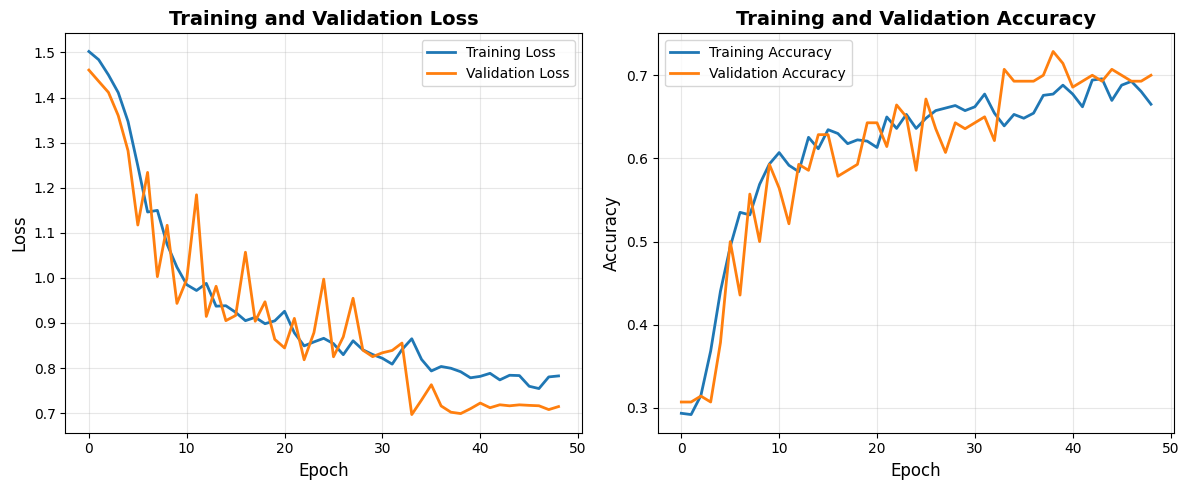

In [ ]:
# Cell 25
# Plot training and validation loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 26
# Evaluate model on test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating on test set...

Test Loss: 0.7524
Test Accuracy: 0.6879


In [ ]:
# Cell 27
# Make predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step


In [ ]:
# Cell 28
# Calculate evaluation metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_classes, average=None, labels=[0, 1, 2, 3, 4]
)

print("\nPer-Class Metrics:")
print("-" * 60)
print(f"{'Stage':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)

for i, stage_name in enumerate(STAGE_NAMES):
    print(f"{stage_name:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

print("-" * 60)

# Weighted averages
weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print(f"\nWeighted Average Metrics:")
print(f"Precision: {weighted_precision:.4f}")
print(f"Recall: {weighted_recall:.4f}")
print(f"F1-Score: {weighted_f1:.4f}")


Per-Class Metrics:
------------------------------------------------------------
Stage      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
Wake       0.7273       0.6667       0.6957       12        
N1         0.6786       0.6129       0.6441       31        
N2         0.6444       0.6591       0.6517       44        
N3         0.7308       0.8837       0.8000       43        
REM        0.6000       0.2727       0.3750       11        
------------------------------------------------------------

Weighted Average Metrics:
Precision: 0.6819
Recall: 0.6879
F1-Score: 0.6774


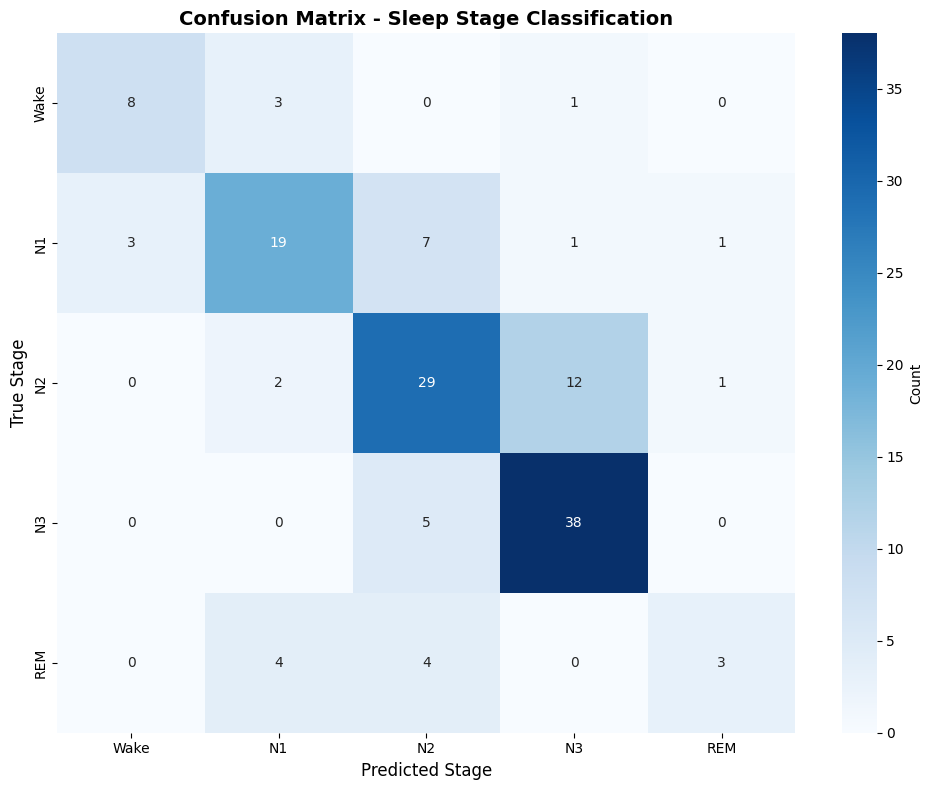

In [ ]:
# Cell 29
# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=STAGE_NAMES,
            yticklabels=STAGE_NAMES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Stage', fontsize=12)
plt.ylabel('True Stage', fontsize=12)
plt.title('Confusion Matrix - Sleep Stage Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

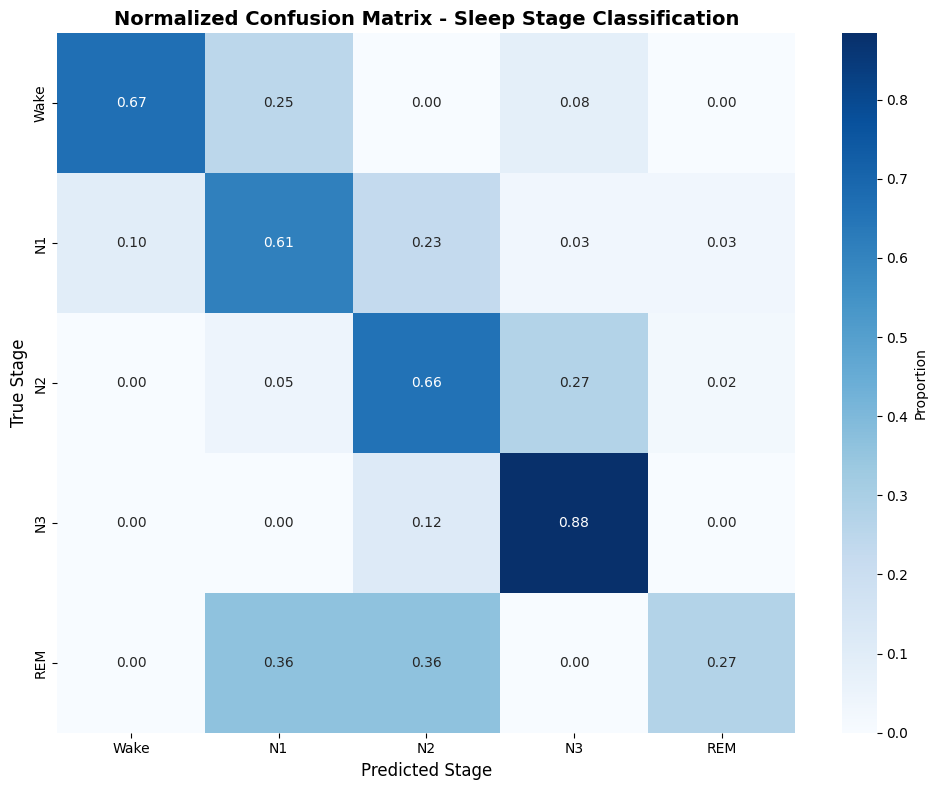

In [ ]:
# Cell 30
# Calculate and plot normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=STAGE_NAMES,
            yticklabels=STAGE_NAMES,
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Stage', fontsize=12)
plt.ylabel('True Stage', fontsize=12)
plt.title('Normalized Confusion Matrix - Sleep Stage Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 31
# Print detailed classification report
print("\nDetailed Classification Report:")
print("=" * 70)
print(classification_report(y_test, y_pred_classes, target_names=STAGE_NAMES))


Detailed Classification Report:
              precision    recall  f1-score   support

        Wake       0.73      0.67      0.70        12
          N1       0.68      0.61      0.64        31
          N2       0.64      0.66      0.65        44
          N3       0.73      0.88      0.80        43
         REM       0.60      0.27      0.38        11

    accuracy                           0.69       141
   macro avg       0.68      0.62      0.63       141
weighted avg       0.68      0.69      0.68       141



In [ ]:
# Cell 32
# Analyze most difficult stages to classify
print("\nAnalysis of Most Difficult Sleep Stages:")
print("-" * 60)

diagonal = np.diag(cm_normalized)
stage_accuracy = {STAGE_NAMES[i]: diagonal[i] for i in range(len(STAGE_NAMES))}

sorted_stages = sorted(stage_accuracy.items(), key=lambda x: x[1])

print("\nStages ranked by classification difficulty (easiest to hardest):")
for i, (stage, acc) in enumerate(reversed(sorted_stages)):
    difficulty = "Easy" if acc > 0.8 else "Moderate" if acc > 0.6 else "Difficult"
    print(f"{i+1}. {stage}: {acc:.2%} accuracy - {difficulty}")


Analysis of Most Difficult Sleep Stages:
------------------------------------------------------------

Stages ranked by classification difficulty (easiest to hardest):
1. N3: 88.37% accuracy - Easy
2. Wake: 66.67% accuracy - Moderate
3. N2: 65.91% accuracy - Moderate
4. N1: 61.29% accuracy - Moderate
5. REM: 27.27% accuracy - Difficult


In [ ]:
# Cell 33
# Analyze misclassifications
print("\nMost Common Misclassifications:")
print("-" * 60)

misclassifications = []
for i in range(len(STAGE_NAMES)):
    for j in range(len(STAGE_NAMES)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((STAGE_NAMES[i], STAGE_NAMES[j], cm[i, j], cm[i, j] / cm[i].sum()))

misclassifications.sort(key=lambda x: x[3], reverse=True)

print(f"{'True Stage':<10} {'Predicted':<10} {'Count':<10} {'Percentage':<10}")
print("-" * 60)
for true_stage, pred_stage, count, percentage in misclassifications[:10]:
    print(f"{true_stage:<10} {pred_stage:<10} {count:<10} {percentage:<10.2%}")


Most Common Misclassifications:
------------------------------------------------------------
True Stage Predicted  Count      Percentage
------------------------------------------------------------
REM        N1         4          36.36%    
REM        N2         4          36.36%    
N2         N3         12         27.27%    
Wake       N1         3          25.00%    
N1         N2         7          22.58%    
N3         N2         5          11.63%    
N1         Wake       3          9.68%     
Wake       N3         1          8.33%     
N2         N1         2          4.55%     
N1         N3         1          3.23%     


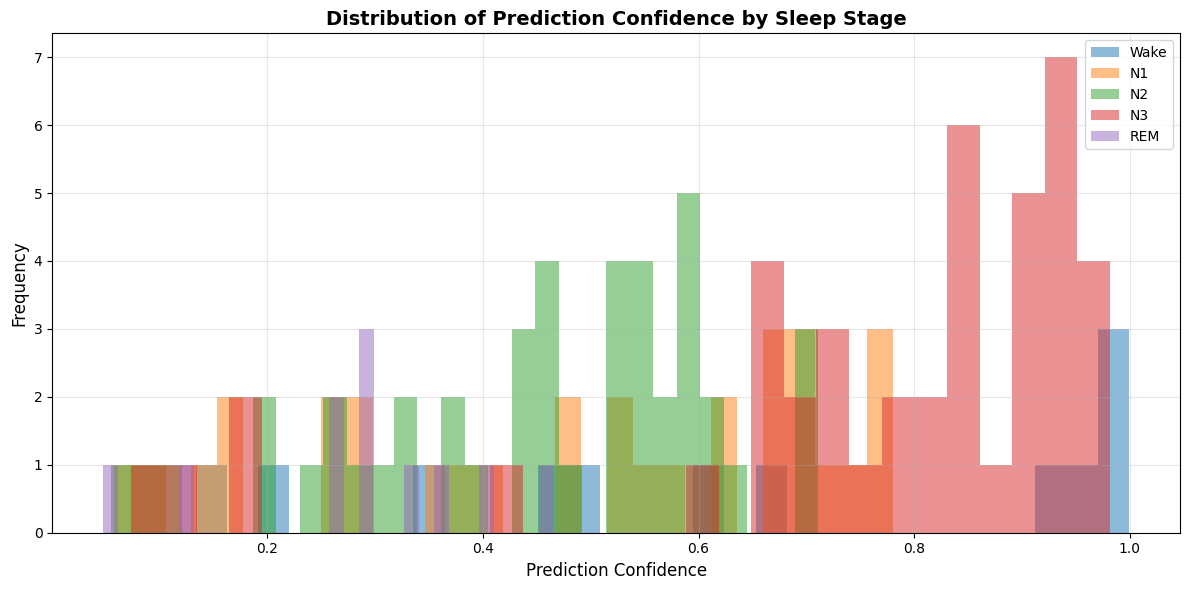

In [ ]:
# Cell 34
# Visualize prediction confidence distribution
plt.figure(figsize=(12, 6))

for i, stage_name in enumerate(STAGE_NAMES):
    stage_mask = y_test == i
    if stage_mask.sum() > 0:
        confidence = y_pred[stage_mask, i]
        plt.hist(confidence, bins=30, alpha=0.5, label=stage_name)

plt.xlabel('Prediction Confidence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Confidence by Sleep Stage', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 35
# Save final results summary to text file
results_file = os.path.join(BASE_PATH, 'results_summary.txt')

with open(results_file, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("SLEEP STAGE CLASSIFICATION USING TCN - RESULTS SUMMARY\n")
    f.write("=" * 70 + "\n\n")

    f.write(f"Dataset: Sleep-EDF Expanded (Subset of 3 subjects)\n")
    f.write(f"Total Epochs: {len(X)}\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Validation Samples: {len(X_val)}\n")
    f.write(f"Test Samples: {len(X_test)}\n\n")

    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Test Loss: {test_loss:.4f}\n\n")

    f.write("Per-Class Metrics:\n")
    f.write("-" * 70 + "\n")
    f.write(f"{'Stage':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}\n")
    f.write("-" * 70 + "\n")

    for i, stage_name in enumerate(STAGE_NAMES):
        f.write(f"{stage_name:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f}\n")

    f.write("\n" + "=" * 70 + "\n")

print(f"Results summary saved to: {results_file}")

Results summary saved to: /content/drive/MyDrive/sleep_edf_data/results_summary.txt


In [ ]:
# Cell 36
# Discussion and conclusion
print("\n" + "="*70)
print("DISCUSSION AND ANALYSIS")
print("="*70)

print("\n1. Model Performance:")
print(f"   - Overall test accuracy: {test_accuracy:.2%}")
print(f"   - The model shows {'good' if test_accuracy > 0.75 else 'moderate' if test_accuracy > 0.6 else 'limited'} performance")

print("\n2. Most Difficult Sleep Stages:")
difficult_stages = [stage for stage, acc in sorted_stages[:2]]
print(f"   - {difficult_stages[0]} and {difficult_stages[1]} were the most challenging")
print("   - N1 is typically difficult due to transitional nature")
print("   - Similarity between adjacent sleep stages causes confusion")

print("\n3. Why TCN is Suitable for EEG Sleep Stage Classification:")
print("   - Captures temporal dependencies in EEG signals")
print("   - Causal convolutions preserve temporal order")
print("   - Dilated convolutions provide large receptive field")
print("   - Efficiently processes long sequences (30-second epochs)")
print("   - Fewer parameters than RNN/LSTM models")
print("   - Parallel processing enables faster training")

print("\n4. Potential Improvements:")
print("   - Use more subjects for better generalization")
print("   - Apply data augmentation techniques")
print("   - Experiment with different TCN architectures")
print("   - Consider class imbalance handling")
print("   - Use multi-channel EEG inputs")

print("\n" + "="*70)


DISCUSSION AND ANALYSIS

1. Model Performance:
   - Overall test accuracy: 68.79%
   - The model shows moderate performance

2. Most Difficult Sleep Stages:
   - REM and N1 were the most challenging
   - N1 is typically difficult due to transitional nature
   - Similarity between adjacent sleep stages causes confusion

3. Why TCN is Suitable for EEG Sleep Stage Classification:
   - Captures temporal dependencies in EEG signals
   - Causal convolutions preserve temporal order
   - Dilated convolutions provide large receptive field
   - Efficiently processes long sequences (30-second epochs)
   - Fewer parameters than RNN/LSTM models
   - Parallel processing enables faster training

4. Potential Improvements:
   - Use more subjects for better generalization
   - Apply data augmentation techniques
   - Experiment with different TCN architectures
   - Consider class imbalance handling
   - Use multi-channel EEG inputs

